# Salary, Gameplay, and Win Percentage: A Case Study of Three Teams
### Ward Anderson, Ben Brown, Jeff Stevens
### Dr. Kretchmar
### 10/22/18

## Introduction

{intro goes here}

In [1]:
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import json

#Include inflation data
inflation = pd.read_csv("conversionfactors.csv")

To eliminate the effect of inflation on our salary time series data, we incorporated inflation adjustment data, courtesy of the Oregon State University Political Science Department (see: https://liberalarts.oregonstate.edu/spp/polisci/research/inflation-conversion-factors-convert-dollars-1774-estimated-2024-dollars-recent-year).

In [2]:
def getCreds(filename,subset,defaults={}):
    '''
    This function helps us connect to a database on hadoop2.  The
    userid password information is stored in a local file encoded
    in json format.  
    Inputs:
        filename is where json encoded userid/password information stored
        subset : dictionary key in json file
        defaults : alternative way to connect to database
    Returns subdictionary based on subset parameter.
    '''
    try:
        with open(filename,'r') as file:
            D = json.load(file)
            file.close()
            if D[subset]:
                return D[subset]
            else:
                return defaults
    except:
        return defaults
     
def db_setup(database):
    template = 'mysql+mysqlconnector://{}:{}@hadoop2.mathsci.denison.edu/{}'
    cstring = template.format(creds['user'],creds['password'],database)
    return cstring

creds = getCreds('creds.json','mysql',defaults = {'user':'steven_j1', 'password':'steven_j1'})

cstring = db_setup("lahman2016")
engine = sa.create_engine(cstring)
connection = engine.connect()

In [3]:
     #-#-#-#-#-#-#-#-#-#-#-#-#-#-#
########## CLEVELAND INDIANS ##########
     #-#-#-#-#-#-#-#-#-#-#-#-#-#-#

query_main = '''SELECT t.yearID, t.teamID, t.franchID, t.H, t.AB, t.W, t.L, t.ERA, t.H/t.AB AS BA, t.W/(t.W+t.L) AS Winpct, t.FP \
FROM Teams AS t \
WHERE franchID = "CLE";'''

getclesal = "SELECT yearID, AVG(salary) AS CleSalary \
FROM Salaries \
WHERE teamID = 'CLE' \
GROUP BY yearID \
ORDER BY yearID;"

#Converting Cleveland Indians query to DataFrame
result = connection.execute(query_main)
rows = result.fetchall()
CleStats = pd.DataFrame(rows,columns = result.keys())
CleStats = CleStats.rename(index = str, columns = {'teamID':'CleTeamID', 'franchID':\
                                                     'CleFranchID', 'H': 'CleH', 'AB':'CleAB', 'W':'CleW', 'L':\
                                                     'CleL', 'ERA': 'CleERA', 'BA':'CleBA', 'Winpct':'CleWinpct', \
                                                     'FP': 'CleFP'})
print("Statistics for The Cleveland Indians Baseball Team since 1901")
print(CleStats)

Statistics for The Cleveland Indians Baseball Team since 1901
     yearID CleTeamID CleFranchID  CleH  CleAB  CleW  CleL  CleERA   CleBA  \
0      1901       CLE         CLE  1311   4833    54    82    4.12  0.2713   
1      1902       CLE         CLE  1401   4840    69    67    3.28  0.2895   
2      1903       CLE         CLE  1265   4773    77    63    2.73  0.2650   
3      1904       CLE         CLE  1340   5152    86    65    2.22  0.2601   
4      1905       CLE         CLE  1318   5166    76    78    2.85  0.2551   
5      1906       CLE         CLE  1516   5426    89    64    2.09  0.2794   
6      1907       CLE         CLE  1221   5068    85    67    2.26  0.2409   
7      1908       CLE         CLE  1221   5108    90    64    2.02  0.2390   
8      1909       CLE         CLE  1216   5048    71    82    2.40  0.2409   
9      1910       CLE         CLE  1316   5385    71    81    2.88  0.2444   
10     1911       CLE         CLE  1501   5321    80    73    3.36  0.2821   
11

In [4]:
     #-#-#-#-#-#-#-#-#-#-#-#-#-#-#
########## WASHINGTON NATIONALS ##########
     #-#-#-#-#-#-#-#-#-#-#-#-#-#-#
    
    
WAS_query = '''SELECT t.yearID, t.teamID, t.franchID, t.H, t.AB, t.W, t.L, t.ERA, t.H/t.AB AS BA, t.W/(t.W+t.L) AS Winpct, t.FP
FROM Teams AS t
WHERE t.franchID = "WSN";'''
resultproxy = connection.execute(WAS_query)

getwsnsal = "SELECT yearID, AVG(salary) AS WsnSalary \
FROM Salaries \
WHERE teamID = 'WSN' \
OR teamID = 'WAS' \
OR teamID = 'MON' \
GROUP BY yearID \
ORDER BY yearID;"

#Converting Washington Nationals query to DataFrame
tmp = connection.execute(WAS_query)
WAS_stats = pd.DataFrame(tmp.fetchall(), columns = tmp.keys())
WAS_stats = WAS_stats.rename(index = str, columns = {'teamID':'WasTeamID', 'franchID':\
                                                     'WasFranchID', 'H': 'WasH', 'AB':'WasAB', 'W':'WasW', 'L':\
                                                     'WasL', 'ERA': 'WasERA', 'BA':'WasBA', 'Winpct':'WasWinpct', \
                                                     'FP': 'WasFP'})
print(WAS_stats)

    yearID WasTeamID WasFranchID  WasH  WasAB  WasW  WasL  WasERA   WasBA  \
0     1969       MON         WSN  1300   5419    52   110    4.33  0.2399   
1     1970       MON         WSN  1284   5411    73    89    4.50  0.2373   
2     1971       MON         WSN  1312   5335    71    90    4.12  0.2459   
3     1972       MON         WSN  1205   5156    70    86    3.59  0.2337   
4     1973       MON         WSN  1345   5369    79    83    3.71  0.2505   
5     1974       MON         WSN  1355   5343    79    82    3.60  0.2536   
6     1975       MON         WSN  1346   5518    75    87    3.72  0.2439   
7     1976       MON         WSN  1275   5428    55   107    3.99  0.2349   
8     1977       MON         WSN  1474   5675    75    87    4.01  0.2597   
9     1978       MON         WSN  1404   5530    76    86    3.42  0.2539   
10    1979       MON         WSN  1445   5465    95    65    3.14  0.2644   
11    1980       MON         WSN  1407   5465    90    72    3.48  0.2575   

In [5]:
     #-#-#-#-#-#-#-#-#-#-#-#-#-#-#
########## CINCINNATI REDS ##########
     #-#-#-#-#-#-#-#-#-#-#-#-#-#-#

getredstats = "SELECT t.yearID, t.teamID, t.franchID, t.H, t.AB, t.W, t.L, t.ERA, t.H/t.AB AS BA, t.W/(t.W+t.L) AS Winpct, t.FP \
FROM Teams AS t \
WHERE t.franchID = 'CIN';"

getredsal = "SELECT yearID, AVG(salary) AS RedsSalary \
FROM Salaries \
WHERE teamID = 'CIN' \
GROUP BY yearID \
ORDER BY yearID;"

#Converting Cincinnati Reds query to DataFrame
tmp = connection.execute(getredstats)
redstats = pd.DataFrame(tmp.fetchall(), columns = tmp.keys())
redstats = redstats.rename(index = str, columns = {'teamID':'CinTeamID', 'franchID':\
                                                     'CinFranchID', 'H': 'CinH', 'AB':'CinAB', 'W':'CinW', 'L':\
                                                     'CinL', 'ERA': 'CinERA', 'BA':'CinBA', 'Winpct':'CinWinpct', \
                                                     'FP': 'CinFP'})
print(redstats)

     yearID CinTeamID CinFranchID  CinH  CinAB  CinW  CinL  CinERA   CinBA  \
0      1882       CN2         CIN   795   3007    55    25    1.65  0.2644   
1      1883       CN2         CIN   961   3669    61    37    2.26  0.2619   
2      1884       CN2         CIN  1037   4090    68    41    3.33  0.2535   
3      1885       CN2         CIN  1046   4050    63    49    3.26  0.2583   
4      1886       CN2         CIN  1225   4915    65    73    4.18  0.2492   
5      1887       CN2         CIN  1285   4797    81    54    3.58  0.2679   
6      1888       CN2         CIN  1161   4801    80    54    2.73  0.2418   
7      1889       CN2         CIN  1307   4844    76    63    3.50  0.2698   
8      1890       CIN         CIN  1204   4644    77    55    2.79  0.2593   
9      1891       CIN         CIN  1158   4791    56    81    3.55  0.2417   
10     1892       CIN         CIN  1288   5349    82    68    3.17  0.2408   
11     1893       CIN         CIN  1195   4617    65    63    4.

In [7]:
#Get salary data
tmp = connection.execute(getredsal)
redsal = pd.DataFrame(tmp.fetchall(), columns = tmp.keys())
tmp = connection.execute(getclesal)
clesal = pd.DataFrame(tmp.fetchall(), columns = tmp.keys())
tmp = connection.execute(getwsnsal)
wsnsal = pd.DataFrame(tmp.fetchall(), columns = tmp.keys())

#Aggregate salary data and inflation data
salary = redsal.merge(clesal, on = "yearID").merge(wsnsal, on = "yearID").merge(inflation, left_on = "yearID", right_on = "Year")
salary = salary.drop("Year", axis = 1)
salary.RedsSalary = pd.to_numeric(salary.RedsSalary)
salary.CleSalary = pd.to_numeric(salary.CleSalary)
salary.WsnSalary = pd.to_numeric(salary.WsnSalary)

#Adjust for inflation
salary.RedsSalary = salary.RedsSalary/salary.Factor
salary.CleSalary = salary.CleSalary/salary.Factor
salary.WsnSalary = salary.WsnSalary/salary.Factor
salary = salary.drop("Factor", axis = 1)

print(salary)

    yearID    RedsSalary     CleSalary     WsnSalary
0     1985  8.655951e+05  7.462034e+05  1.078607e+06
1     1986  8.878738e+05  5.635780e+05  7.762584e+05
2     1987  7.710168e+05  6.567225e+05  6.247347e+05
3     1988  7.361001e+05  8.410032e+05  7.953071e+05
4     1989  7.545318e+05  6.656785e+05  9.745475e+05
5     1990  7.929588e+05  8.236398e+05  1.003836e+06
6     1991  1.819683e+06  1.057254e+06  1.135456e+06
7     1992  2.326567e+06  4.681840e+05  1.024497e+06
8     1993  2.305068e+06  7.864831e+05  8.213530e+05
9     1994  2.184049e+06  1.439929e+06  1.127391e+06
10    1995  2.040130e+06  1.742666e+06  6.023580e+05
11    1996  1.898497e+06  2.424766e+06  8.197833e+05
12    1997  1.899542e+06  2.797462e+06  9.502832e+05
13    1998  1.017470e+06  2.770570e+06  4.849168e+05
14    1999  1.611137e+06  2.824244e+06  7.522269e+05
15    2000  2.469164e+06  4.151481e+06  1.618401e+06
16    2001  2.509400e+06  4.294698e+06  1.568710e+06
17    2002  2.045885e+06  3.583535e+06  1.8815

In [8]:
CleSalarySub = salary.loc[:, ['yearID','CleSalary']]
print(CleSalarySub)

WasSalarySub = salary.loc[:, ['yearID','WsnSalary']]
WasSalarySub = WasSalarySub.rename(index = str, columns = {'WsnSalary':'WasSalary'})
print(WasSalarySub)

RedSalarySub = salary.loc[:, ['yearID','RedsSalary']]
RedSalarySub = RedSalarySub.rename(index = str, columns = {'RedsSalary': 'CinSalary'})
print(RedSalarySub)

    yearID     CleSalary
0     1985  7.462034e+05
1     1986  5.635780e+05
2     1987  6.567225e+05
3     1988  8.410032e+05
4     1989  6.656785e+05
5     1990  8.236398e+05
6     1991  1.057254e+06
7     1992  4.681840e+05
8     1993  7.864831e+05
9     1994  1.439929e+06
10    1995  1.742666e+06
11    1996  2.424766e+06
12    1997  2.797462e+06
13    1998  2.770570e+06
14    1999  2.824244e+06
15    2000  4.151481e+06
16    2001  4.294698e+06
17    2002  3.583535e+06
18    2003  2.086888e+06
19    2004  1.483757e+06
20    2005  1.795634e+06
21    2006  2.726594e+06
22    2007  2.513788e+06
23    2008  3.459351e+06
24    2009  3.453086e+06
25    2010  2.371328e+06
26    2011  1.832190e+06
27    2012  2.886332e+06
28    2013  2.848564e+06
29    2014  3.270899e+06
30    2015  3.126048e+06
31    2016  2.811331e+06
    yearID     WasSalary
0     1985  1.078607e+06
1     1986  7.762584e+05
2     1987  6.247347e+05
3     1988  7.953071e+05
4     1989  9.745475e+05
5     1990  1.003836e+06


In [9]:
CleStats = pd.merge(CleSalarySub, CleStats, on = 'yearID')

WAS_stats = pd.merge(WasSalarySub, WAS_stats, on = 'yearID')
print(WAS_stats)

redstats = pd.merge(RedSalarySub, redstats, on= 'yearID')
print(redstats)

    yearID     WasSalary WasTeamID WasFranchID  WasH  WasAB  WasW  WasL  \
0     1985  1.078607e+06       MON         WSN  1342   5429    84    77   
1     1986  7.762584e+05       MON         WSN  1401   5508    78    83   
2     1987  6.247347e+05       MON         WSN  1467   5527    91    71   
3     1988  7.953071e+05       MON         WSN  1400   5573    81    81   
4     1989  9.745475e+05       MON         WSN  1353   5482    81    81   
5     1990  1.003836e+06       MON         WSN  1363   5453    85    77   
6     1991  1.135456e+06       MON         WSN  1329   5412    71    90   
7     1992  1.024497e+06       MON         WSN  1381   5477    87    75   
8     1993  8.213530e+05       MON         WSN  1410   5493    94    68   
9     1994  1.127391e+06       MON         WSN  1111   4000    74    40   
10    1995  6.023580e+05       MON         WSN  1268   4905    66    78   
11    1996  8.197833e+05       MON         WSN  1441   5505    88    74   
12    1997  9.502832e+05 

In [13]:
CleWasSTATS = pd.merge(CleStats, WAS_stats, on='yearID')
CleWasCinSTATS = pd.merge(CleWasSTATS, redstats, on = 'yearID')
print(CleWasCinSTATS)

    yearID     CleSalary CleTeamID CleFranchID  CleH  CleAB  CleW  CleL  \
0     1985  7.462034e+05       CLE         CLE  1465   5527    60   102   
1     1986  5.635780e+05       CLE         CLE  1620   5702    84    78   
2     1987  6.567225e+05       CLE         CLE  1476   5606    61   101   
3     1988  8.410032e+05       CLE         CLE  1435   5505    78    84   
4     1989  6.656785e+05       CLE         CLE  1340   5463    73    89   
5     1990  8.236398e+05       CLE         CLE  1465   5485    77    85   
6     1991  1.057254e+06       CLE         CLE  1390   5470    57   105   
7     1992  4.681840e+05       CLE         CLE  1495   5620    76    86   
8     1993  7.864831e+05       CLE         CLE  1547   5619    76    86   
9     1994  1.439929e+06       CLE         CLE  1165   4022    66    47   
10    1995  1.742666e+06       CLE         CLE  1461   5028   100    44   
11    1996  2.424766e+06       CLE         CLE  1665   5681    99    62   
12    1997  2.797462e+06 

In [14]:
CleWasCinSTATS.to_csv('CleWasCinSTATS.csv')

## Analysis

In order to assess the impact of player salaries on win percentage, we plotted win percentage against year, overlaid with information about average salary per team. Salaries were converted to 2017 dollars with the help of the inflation data from Oregon State University. 

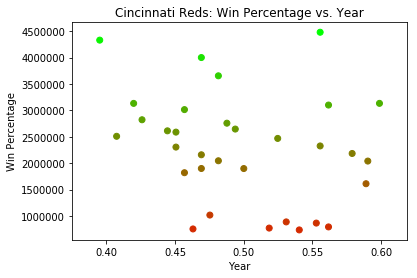

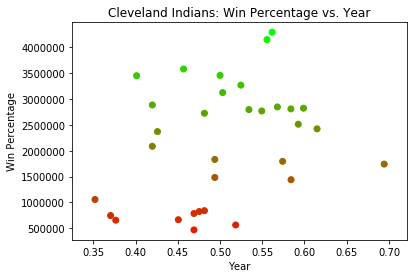

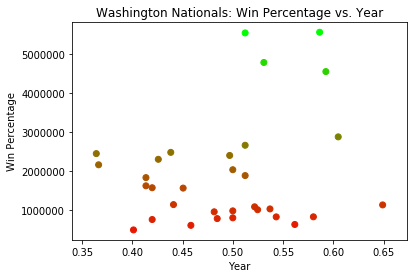

In [17]:
def scaleColors(sal):
    '''
    This function takes numeric data (presumably salary data) and returns a list of scaled colors
    representing how close each value falls to the min or max of the input data
    Parameters: a series of numeric data
    Return: a list of color triples
    '''
    colors = []
    mx = max(sal)
    for i in sal:
        colors.append( (1-i/mx, i/mx, 0) )
    return colors

redCol = scaleColors(salary.RedsSalary)
cleCol = scaleColors(salary.CleSalary)
wsnCol = scaleColors(salary.WsnSalary)

plt.scatter(CleWasCinSTATS.CinWinpct[CleWasCinSTATS.yearID >= min(salary.yearID)], salary.RedsSalary, c = redCol)
                                                            #not sure about how to change second half accodring to 
                                                            #massive table
plt.xlabel("Year")
plt.ylabel("Win Percentage")
plt.title("Cincinnati Reds: Win Percentage vs. Year")
plt.show()

plt.scatter(CleWasCinSTATS.CleWinpct[CleWasCinSTATS.yearID >= min(salary.yearID)], salary.CleSalary, c = cleCol)
                                                            #not sure about how to change second half accodring to 
                                                            #massive table
plt.xlabel("Year")
plt.ylabel("Win Percentage")
plt.title("Cleveland Indians: Win Percentage vs. Year")
plt.show()

plt.scatter(CleWasCinSTATS.WasWinpct[CleWasCinSTATS.yearID >= min(salary.yearID)], salary.WsnSalary, c = wsnCol)
                                                            #not sure about how to change second half accodring to 
                                                            #massive table
plt.xlabel("Year")
plt.ylabel("Win Percentage")
plt.title("Washington Nationals: Win Percentage vs. Year")
plt.show()


Above, green points represent high values of salary, while red points represent low values.